In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


Extract the picture features function

In [5]:
DATA_PATH = "cell_images/"
PARA_PATH = os.path.join(DATA_PATH, "Parasitized")
UNINF_PATH = os.path.join(DATA_PATH, "Uninfected")
IMG_SIZE = (64,64)
images, labels = [], []

def extract_features(img):
    img=cv2.resize(img, IMG_SIZE)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    features=[]
    for i in range(3):
        features.append(np.mean(hsv[:,:,i]))
        features.append(np.std(hsv[:,:,i]))
        
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray=cv2.GaussianBlur(gray, (1,1), 0)
    
    edges = cv2.Canny(gray, 100, 200)
    features.append(np.sum(edges>0)/edges.size)
    
    hist = cv2.calcHist([gray], [0], None, [5], [0,256])
    hist = hist.flatten()/hist.sum()
    features.extend(hist)
    
    return np.array(features)

Load images and label them

In [6]:
for image in os.listdir(PARA_PATH):
    img_path = os.path.join(PARA_PATH, image)
    img= cv2.imread(img_path)
    if img is None:
        continue
    img = extract_features(img)
    images.append(img)
    labels.append(1)
    
for image in os.listdir(UNINF_PATH):
    img_path = os.path.join(UNINF_PATH, image)
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = extract_features(img)
    images.append(img)
    labels.append(0)
    
images = np.array(images)
labels = np.array(labels)

print("Feature vector: ", images.shape[1])


Feature vector:  12


Train-test split, pca, scaling

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42, stratify=labels)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

K-Means Clustering

KMeans Accuracy:0.62


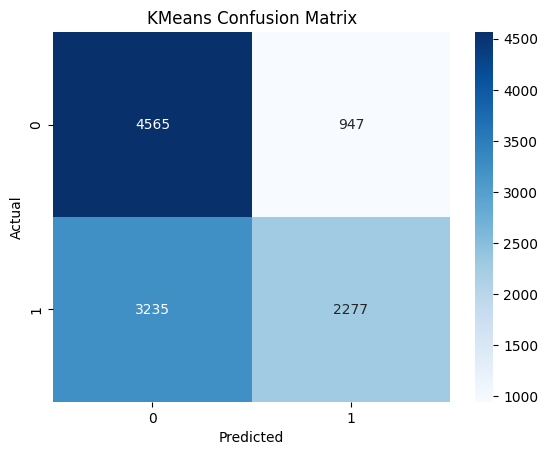

In [8]:
#KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=20)
train_clusters = kmeans.fit_predict(X_train_pca)

mapping = {}
for cluster in range(2):
    indices = np.where(train_clusters == cluster)[0]
    assigned_labels = y_train[indices]
    most_common = Counter(assigned_labels).most_common(1)[0][0]
    mapping[cluster] = most_common

y_pred_k=np.array([mapping[cluster] for cluster in kmeans.predict(X_test_pca)])
print("KMeans Accuracy:{:.2f}".format(accuracy_score(y_test, y_pred_k)))

cm = confusion_matrix(y_test, y_pred_k)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('KMeans Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Now Logistic Regression

Logistic Regression Accuracy: 0.88


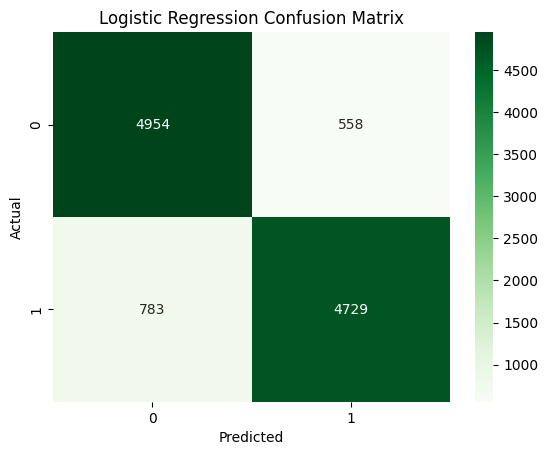

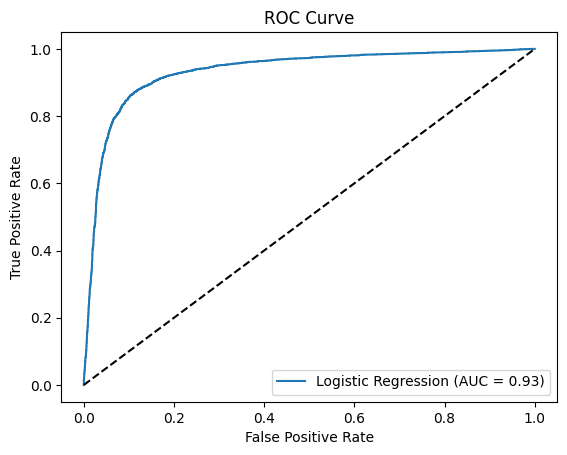

In [9]:
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

print("Logistic Regression Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_lr)))

cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_prob = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()